<a href="https://colab.research.google.com/github/bori00/BreastCancerSegmentation/blob/main/Breast_Cancer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background

* Dataset: https://github.com/PathologyDataScience/BCSS
* Paper: https://academic.oup.com/bioinformatics/article/35/18/3461/5307750

# Setup: Importing the libraries and the dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import urllib
from urllib import request

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
import numpy as np

import cv2
import os

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [2]:
# mount google drive on the virtual machine created by colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Loading Images and Masks, Create Dataset

In [3]:
TEST_RATIO = 0.2
SEED = 123
IMG_HEIGHT = 572
IMG_WIDTH = 572
BATCH_SIZE = 32
MAX_DATASET_SIZE = 30

In [4]:
IMAGES_DIRECTORY = '/content/rgbs_colorNormalized';
MASKS_DIRECTORY = '/content/masks'

In [5]:
!unzip gdrive/My\ Drive/PRS_Project/masks-20221122T203004Z-001.zip 
!unzip gdrive/My\ Drive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-001.zip
!unzip gdrive/My\ Drive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-002.zip
!unzip gdrive/My\ Drive/PRS_Project/rgbs_colorNormalized-20221122T211021Z-003.zip

Archive:  gdrive/My Drive/PRS_Project/masks-20221122T203004Z-001.zip
  inflating: masks/TCGA-A7-A26F-DX1_xmin72969_ymin11489_MPP-0.2500.png  
  inflating: masks/TCGA-AN-A0AL-DX1_xmin15698_ymin29806_MPP-0.2500.png  
  inflating: masks/TCGA-AO-A12F-DX1_xmin16484_ymin29374_MPP-0.2500.png  
  inflating: masks/TCGA-C8-A131-DX1_xmin43049_ymin10894_MPP-0.2500.png  
  inflating: masks/TCGA-A7-A4SE-DX1_xmin50530_ymin11318_MPP-0.2500.png  
  inflating: masks/TCGA-A2-A04T-DX1_xmin72145_ymin39078_MPP-0.2500.png  
  inflating: masks/TCGA-AR-A1AY-DX1_xmin62652_ymin27061_MPP-0.2500.png  
  inflating: masks/TCGA-E2-A14X-DX1_xmin88836_ymin66393_MPP-0.2500.png  
  inflating: masks/TCGA-AC-A2QJ-DX1_xmin36620_ymin8672_MPP-0.2500.png  
  inflating: masks/TCGA-A2-A0D2-DX1_xmin96887_ymin22299_MPP-0.2500.png  
  inflating: masks/TCGA-C8-A1HJ-DX1_xmin46412_ymin17174_MPP-0.2500.png  
  inflating: masks/TCGA-A2-A3XX-DX1_xmin69942_ymin41560_MPP-0.2500.png  
  inflating: masks/TCGA-E2-A1LS-DX1_xmin39247_ymin47756_

In [8]:
def toInt(image):
    return tf.cast(image, tf.int32)

In [9]:
def opencv_image_to_tensor(img):
  res = tf.convert_to_tensor(img, dtype=tf.int32)
  return res

In [10]:
def load_images_and_masks(images_folder, masks_folder):
    images = []
    masks = []
    dim = (IMG_WIDTH, IMG_HEIGHT)
    for idx, filename in enumerate(os.listdir(images_folder)):
        if idx == MAX_DATASET_SIZE:
          break
        img = cv2.imread(os.path.join(images_folder,filename))
        img = cv2.resize(img, dim)
        mask = cv2.imread(os.path.join(masks_folder, filename), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, dim)
        print("Loaded image {0}: {1}".format(idx, filename))
        if img is not None:
            assert mask is not None
            images.append(img.astype(np.int32))
            masks.append(mask.reshape(IMG_HEIGHT, IMG_WIDTH, 1).astype(np.int32))
    return images, masks

In [11]:
images, masks = load_images_and_masks(IMAGES_DIRECTORY, MASKS_DIRECTORY)

Loaded image 0: TCGA-A2-A3XX-DX1_xmin69942_ymin41560_MPP-0.2500.png
Loaded image 1: TCGA-AQ-A54N-DX1_xmin32440_ymin26558_MPP-0.2500.png
Loaded image 2: TCGA-A2-A0YE-DX1_xmin59206_ymin33505_MPP-0.2500.png
Loaded image 3: TCGA-AR-A0TU-DX1_xmin88352_ymin23098_MPP-0.2500.png
Loaded image 4: TCGA-GI-A2C9-DX1_xmin20882_ymin11843_MPP-0.2500.png
Loaded image 5: TCGA-E2-A574-DX1_xmin54962_ymin47475_MPP-0.2500.png
Loaded image 6: TCGA-S3-AA15-DX1_xmin55486_ymin28926_MPP-0.2500.png
Loaded image 7: TCGA-A1-A0SP-DX1_xmin6798_ymin53719_MPP-0.2500.png
Loaded image 8: TCGA-AN-A0XU-DX1_xmin26118_ymin18441_MPP-0.2500.png
Loaded image 9: TCGA-EW-A3U0-DX1_xmin113512_ymin48566_MPP-0.2500.png
Loaded image 10: TCGA-LL-A73Y-DX1_xmin68117_ymin49445_MPP-0.2500.png
Loaded image 11: TCGA-AR-A5QQ-DX1_xmin107130_ymin49863_MPP-0.2500.png
Loaded image 12: TCGA-AN-A0G0-DX1_xmin32741_ymin14546_MPP-0.2500.png
Loaded image 13: TCGA-BH-A0BW-DX1_xmin42346_ymin30843_MPP-0.2500.png
Loaded image 14: TCGA-GM-A2DF-DX1_xmin50637

In [12]:
print("Nr of images read: {0}".format(len(images)))

Nr of images read: 30


In [13]:
image = images[0]
mask = masks[0]
print("Image shape: {0}; Mask shape: {1}".format(image.shape, mask.shape))

Image shape: (572, 572, 3); Mask shape: (572, 572, 1)


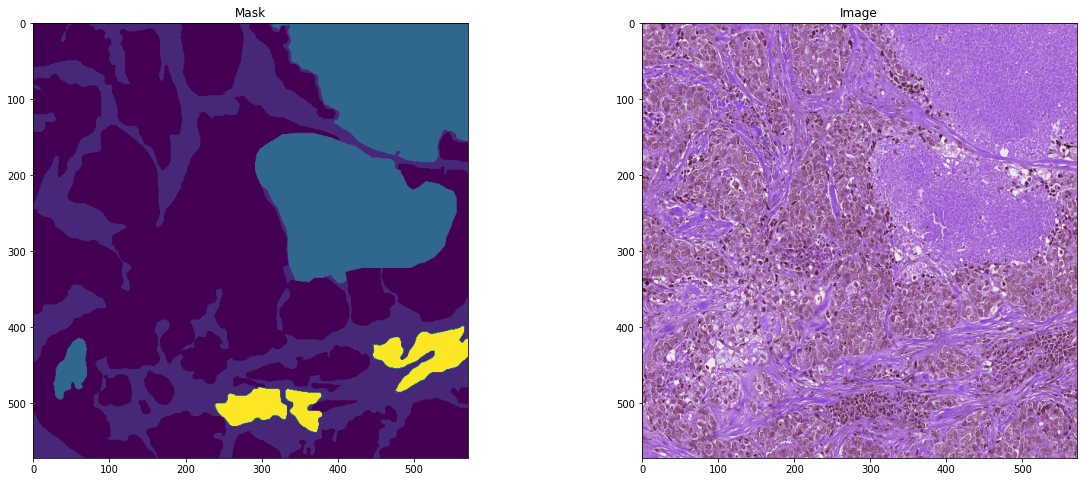

In [14]:
# sample
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.imshow(mask.reshape(IMG_HEIGHT, IMG_WIDTH))
plt.title("Mask")

plt.subplot(1, 2, 2)
plt.imshow(image)
plt.title("Image")

plt.show()

In [15]:
data = tf.data.Dataset.from_tensor_slices((images, masks))

In [16]:
print("Total Dataset Size: {0}".format(tf.data.experimental.cardinality(data).numpy()))

Total Dataset Size: 30


In [17]:
def get_dataset_partitions_tf(ds, ds_size, train_split=1.0 - 2*TEST_RATIO, val_split=TEST_RATIO, test_split=TEST_RATIO, shuffle=True, shuffle_size=10000):
    # source: https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(data, tf.data.experimental.cardinality(data).numpy())

In [19]:
train_batches = (
    train_ds
    .cache()
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = val_ds.batch(BATCH_SIZE)
test_batches = test_ds.batch(BATCH_SIZE)

## Old Code

In [49]:
# setting dictionary for the tf_data_dataset parameters
tf_Dataset_args=dict(labels=None,
                     label_mode=None,
                     validation_split=TEST_RATIO,
                     batch_size=BATCH_SIZE,
                     image_size=(IMG_HEIGHT, IMG_WIDTH),
                     seed=SEED
                     )

In [ ]:
# train_images_ds = tf.keras.utils.image_dataset_from_directory(
#   IMAGES_DIRECTORY,
#   **tf_Dataset_args,
#   subset="training").map(toInt)

# test_images_ds = tf.keras.utils.image_dataset_from_directory(
#   IMAGES_DIRECTORY,
#   **tf_Dataset_args,
#   subset="validation").map(toInt)

In [ ]:
# train_masks_ds = tf.keras.utils.image_dataset_from_directory(
#   MASKS_DIRECTORY,
#    **tf_Dataset_args,
#   subset="training").map(toInt)

# test_masks_ds = tf.keras.utils.image_dataset_from_directory(
#    MASKS_DIRECTORY,
#    **tf_Dataset_args,
#   subset="validation").map(toInt)

In [ ]:
# train_set=list(zip(train_images_ds, train_masks_ds))

In [ ]:
# test_set=list(zip(test_images_ds, test_masks_ds))

In [ ]:
# training_data = tf.data.Dataset.from_tensor_slices(train_set)
# test_data = tf.data.Dataset.from_tensor_slices(test_set)

## Loading the Class Definitions

In [23]:
classes_df = pd.read_csv("gtruth_codes.csv")
classes_df

,label,GT_code
0,outside_roi,0
1,tumor,1
2,stroma,2
3,lymphocytic_infiltrate,3
4,necrosis_or_debris,4
5,glandular_secretions,5
6,blood,6
7,exclude,7
8,metaplasia_NOS,8
9,fat,9


**Important**: The "outside_roi" class is "don't case", not "others", and should be assigned weight 0 in the model.

# Exploratory Data Analysis

## From the images in the drive folders

In [161]:
def plot_image_and_mask(image_name):
  plt.figure(figsize=(20, 8))
  plt.suptitle("Image: " + image_name)

  plt.subplot(1, 2, 1)
  mask = mpimg.imread(MASKS_DIRECTORY + image_name)
  plt.imshow(mask)
  plt.title("Mask")
  
  plt.subplot(1, 2, 2)
  image = mpimg.imread(IMAGES_DIRECTORY + image_name)
  plt.imshow(image)
  plt.title("Image")

  plt.show()

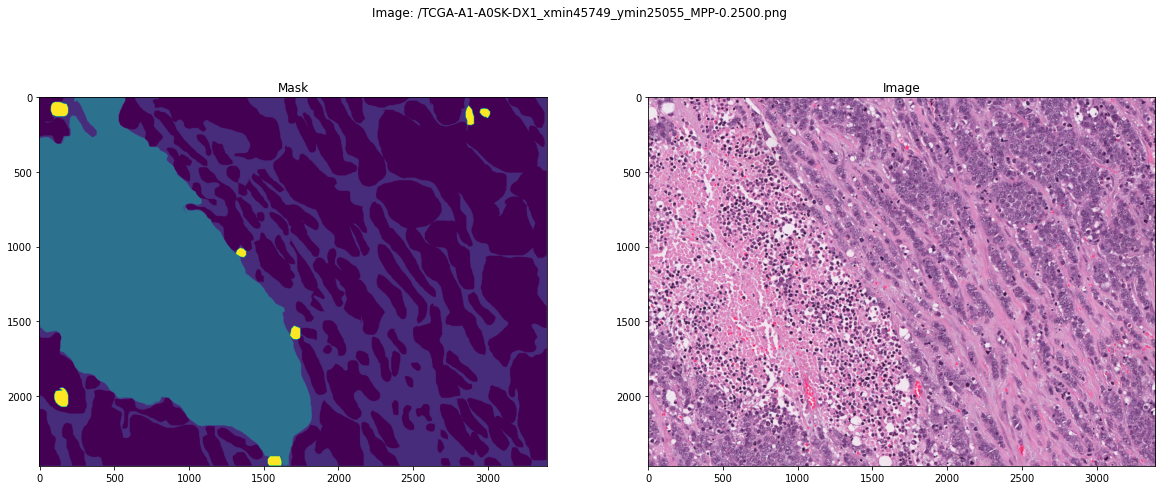

In [40]:
plot_image_and_mask('/TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0.2500.png')

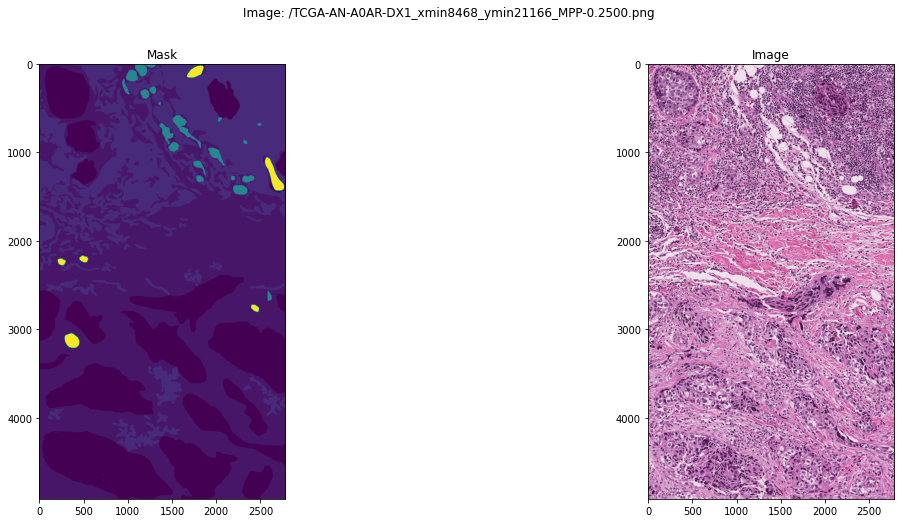

In [41]:
plot_image_and_mask('/TCGA-AN-A0AR-DX1_xmin8468_ymin21166_MPP-0.2500.png')

## From the Dataset

In [162]:
def display(display_list):
  # source: https://www.tensorflow.org/tutorials/images/segmentation
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

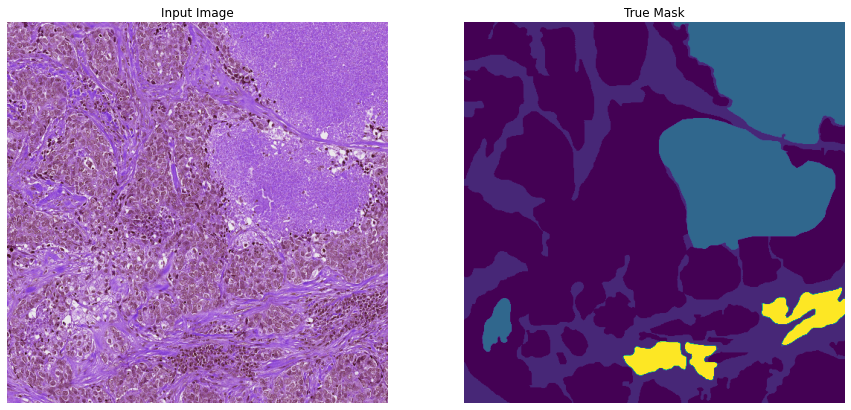

In [164]:
for image, mask in train_batches.take(1):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

# Initial Model: U-NET

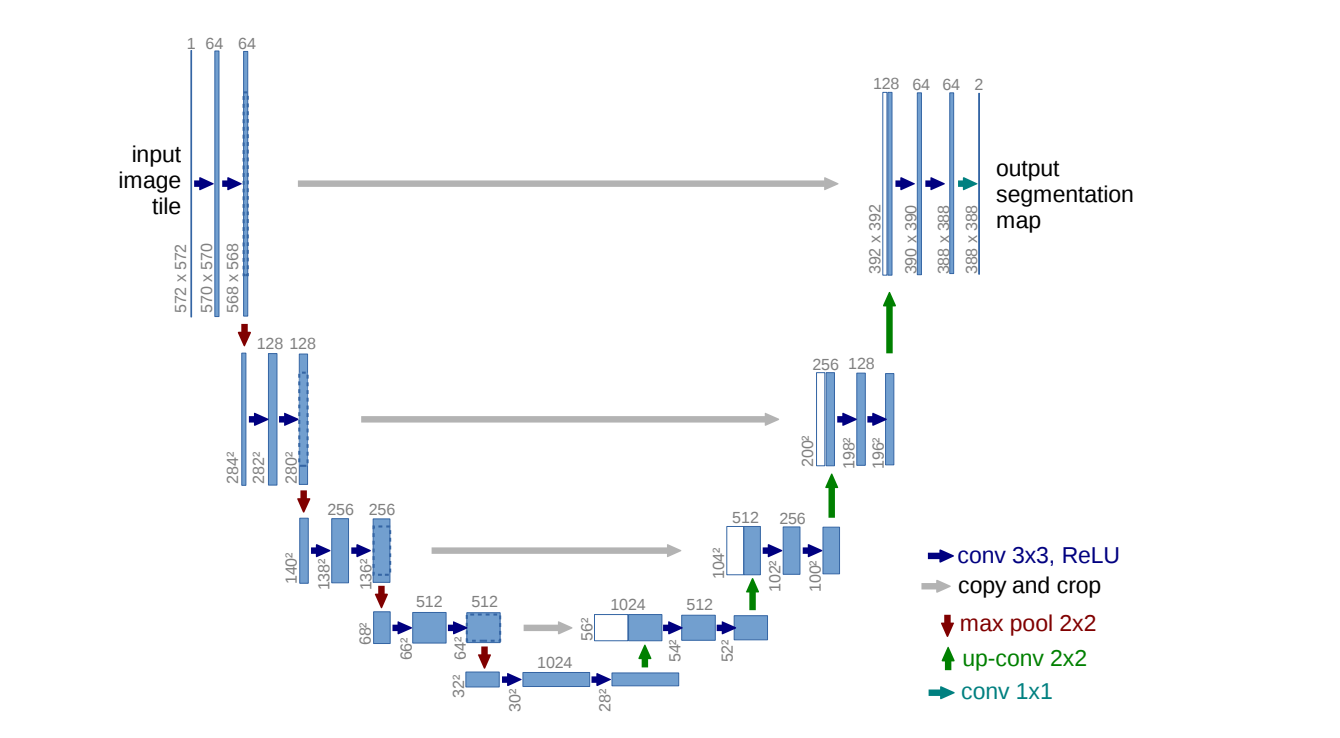

In [24]:
nr_classes = len(classes_df)

In [25]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "valid", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "valid", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [26]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
  #  p = layers.Dropout(0.3)(p)
   return f, p

In [69]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.UpSampling2D(size=(2, 2))(x)

   # crop
   crop = int((conv_features.shape[1] - x.shape[1]) / 2)
   conv_features = layers.Cropping2D(cropping=crop)(conv_features)

   # concatenate
   x = layers.concatenate([x, conv_features])

   # dropout
   #  x = layers.Dropout(0.3)(x)

   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [70]:
def build_unet_model():
  # inputs
  inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

  # encoder: contracting path - downsample
  # according to the paper, we need to double the number of feature channels at each step
  # 1 - downsample
  f1, p1 = downsample_block(inputs, 64)
  print(f1.shape)
  # 2 - downsample
  f2, p2 = downsample_block(p1, 128)
  print(f2.shape)
  # 3 - downsample
  f3, p3 = downsample_block(p2, 256)
  print(f3.shape)
  # 4 - downsample
  f4, p4 = downsample_block(p3, 512)
  print(f4.shape)


  # 5 - bottleneck
  bottleneck = double_conv_block(p4, 1024)
  print(bottleneck.shape)


  # decoder: expanding path - upsample
  # 6 - upsample
  u6 = upsample_block(bottleneck, f4, 512)
  print(u6.shape)
  # 7 - upsample
  u7 = upsample_block(u6, f3, 256)
  print(u7.shape)
  # 8 - upsample
  u8 = upsample_block(u7, f2, 128)
  print(u8.shape)
  # 9 - upsample
  u9 = upsample_block(u8, f1, 64)
  print(u9.shape)

  # outputs
  outputs = layers.Conv2D(nr_classes, 1, padding="same", activation = "softmax")(u9)

  # unet model with Keras Functional API
  unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
  return unet_model

In [71]:
unet_model = build_unet_model()

(None, 568, 568, 64)
(None, 280, 280, 128)
(None, 136, 136, 256)
(None, 64, 64, 512)
(None, 28, 28, 1024)
(None, 52, 52, 512)
(None, 100, 100, 256)
(None, 196, 196, 128)
(None, 388, 388, 64)


In [72]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy",
                  run_eagerly=True)

In [73]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 572, 572, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_150 (Conv2D)            (None, 570, 570, 64  1792        ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_151 (Conv2D)            (None, 568, 568, 64  36928       ['conv2d_150[0][0]']             
                                )                                                             

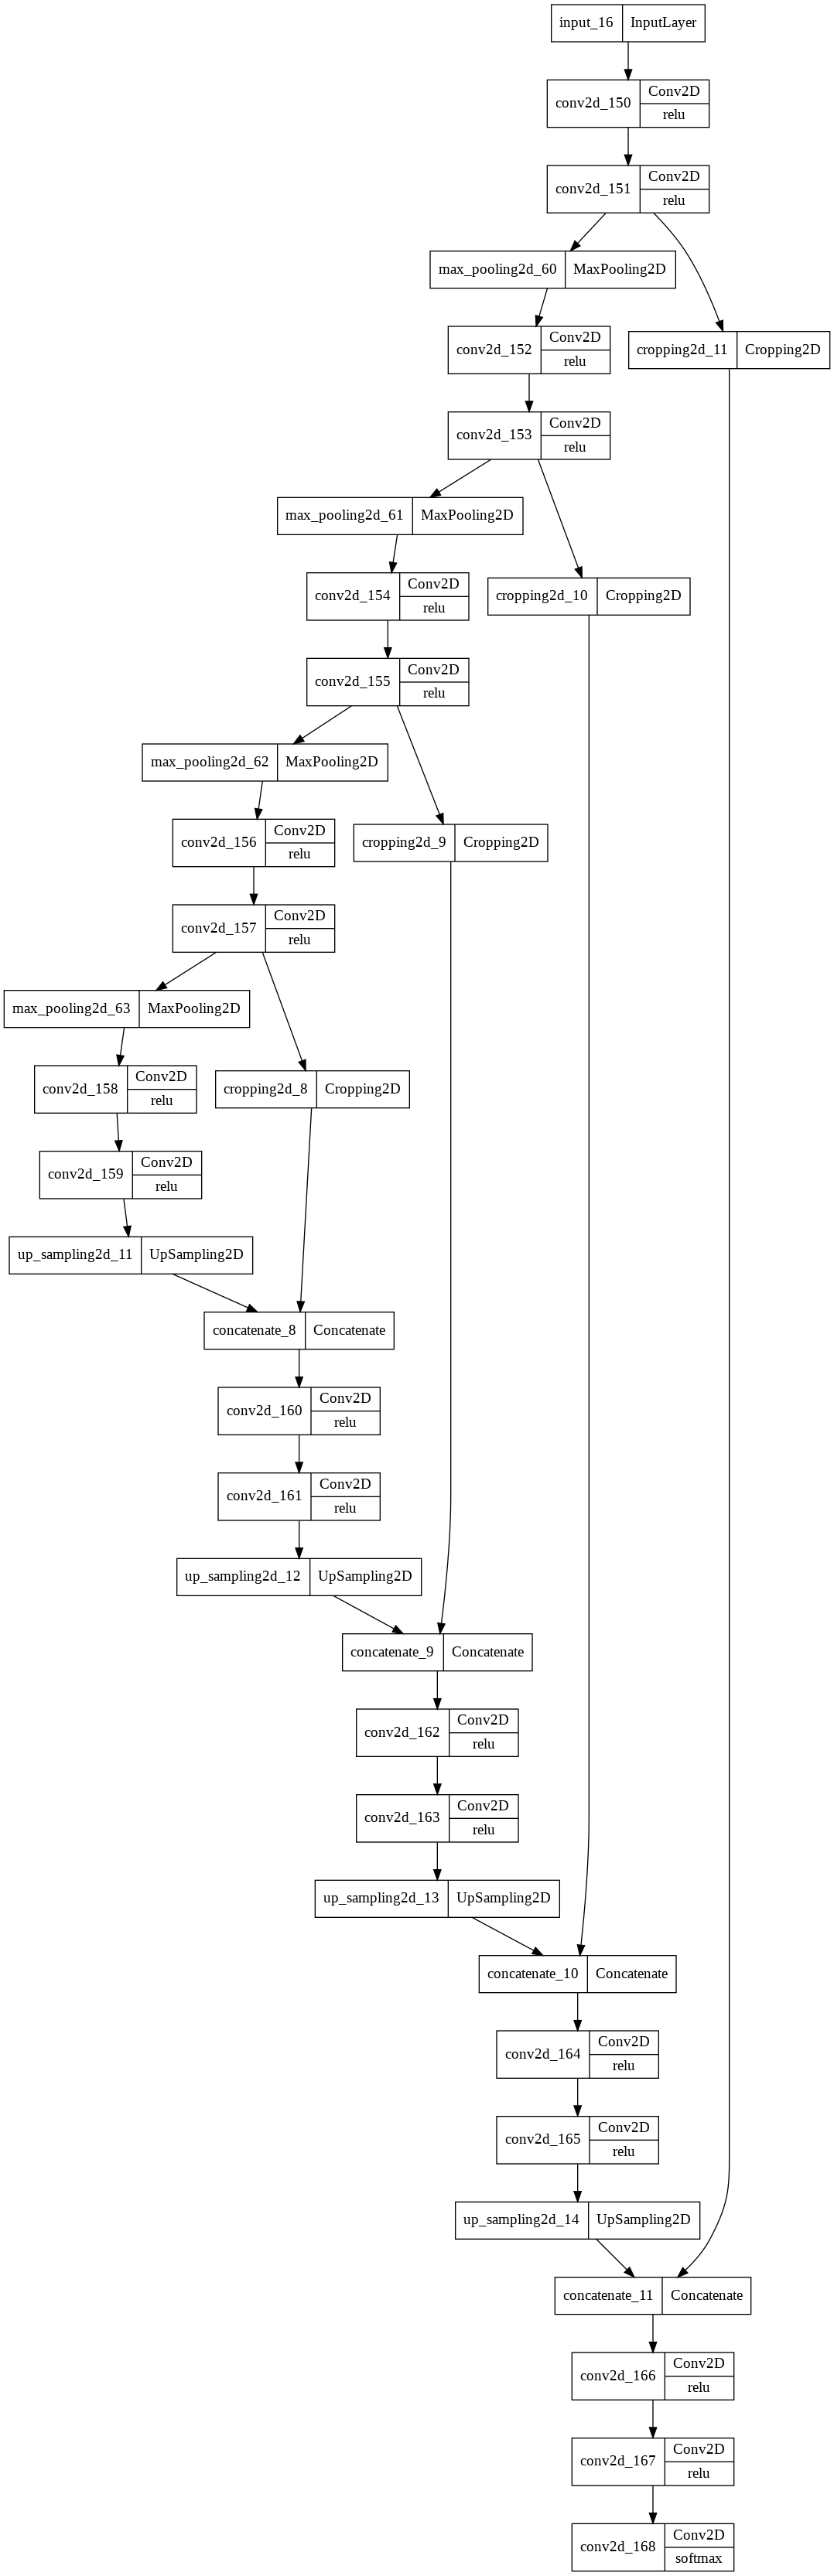

In [74]:
tf.keras.utils.plot_model(unet_model, show_layer_activations=True)

In [75]:
NUM_EPOCHS = 20

TRAIN_LENGTH = len(train_ds)
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
VAL_LENGTH = len(val_ds)
VALIDATION_STEPS = VAL_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/20


ValueError: ignored